# <font  color = "#0093AF"> Exchange Spectroscopy (EXSY)

In the previous example, we simulated exchange in a 1D spectrum. Here, we perform the 2D EXSY experiment, under exchange conditions. We will then look how it results in a 2D EXSY spectrum, and how that spectrum changes as a function of a mixing time.

## Setup

In [2]:
import os
os.chdir('../../../')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the system
The first step is to build the system, which will have a single nucleus, with two different chemical shifts.

In [3]:
ex0=sl.ExpSys(Nucs='13C',v0H=600)    #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=-5)   #Add the chemical shifts
_=ex1.set_inter(Type='CS',i=0,ppm=5)

## Add the exchange process
First, export this sytem into Liouville space, allowing us to introduce an exchange process. Then we'll define a correlation time and population 1 and population 2. From this we can build the exchange matrix and append it to the Liouvillian. We also add some $T_2$ relaxation to destroy transverse magnetization during the delay period for exchange and produce some broadening.

In [4]:
L=sl.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

tc=1     #Correlation time (1 s)
p1=0.75  #Population of state 1
p2=1-p1  #Population of state 2

L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)

_=L.add_relax(Type='T2',i=0,T2=.01)

## Run as a 2D experiment
First, we'll just calculate one 2D spectrum, and then later check how the spectrum evolves as a function of a delay time. We need an initial density matrix, $S_x$, a detection matrix, $S^+$, and propagators for evolution times, $\pi$/2 pulses, and a delay for the exchange process. We start with generating the propagators and density matrices.

SLEEPY has a function in Tools, the TwoD_Builder, for executing and processing two-dimensional experiements. TwoD_Builder requires an initial density matrix, a Sequence for the indirect dimension evolution, the direction dimension evolution, and transfer periods between the dimensions. For the transfer, one needs a sequence to convert the X component, and one for the Y component (States acquisition). THe sequences for the direct/indirect dimension may just be delays.

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


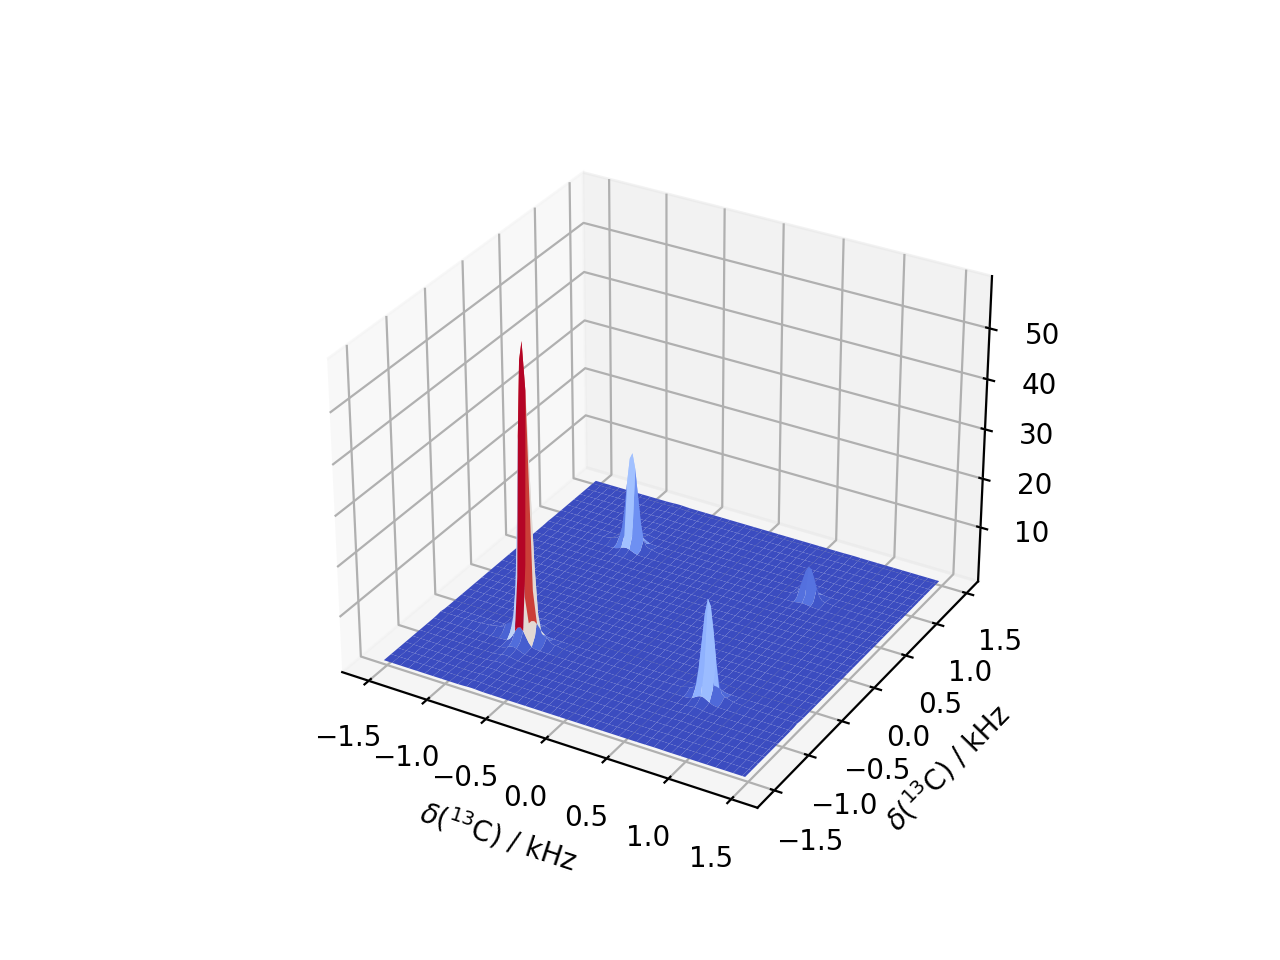

In [9]:
rho=sl.Rho(rho0='S0x',detect='S0p')
# L.Udelta('13C',np.pi/2,np.pi/2)*rho

Dt=1/(2*10*150)  #Delay for a spectrum about twice as broad as the chemical shift difference
seq=L.Sequence(Dt=Dt)  #Sequence for indirect and direct dimensions
seq_trX=L.Sequence()  #X-component of transfer
seq_trY=L.Sequence()  #Y-component of transfer

v1=50000     #pi/2 pulse field strength
tpi2=1/v1/4  #pi/2 pulse length
dly=5
t=[0,tpi2,dly,dly+tpi2] #pi/2 pulse, 1 second delay, pi/2 pulse
seq_trX.add_channel('13C',t=t,v1=[v1,0,v1],phase=[-np.pi/2,0,np.pi/2]) #Convert x to z, delay, convert z to x
seq_trY.add_channel('13C',t=t,v1=[v1,0,v1],phase=[0,0,np.pi/2]) #Convert y to z, delay, convert z to x


twoD=sl.Tools.TwoD_Builder(rho,seq_dir=seq,seq_in=seq,seq_trX=seq_trX,seq_trY=seq_trY)
twoD(32,64)

ax=twoD.plot()
ax.set_xlabel(r'$\delta$($^{13}$C) / kHz')
_=ax.set_ylabel(r'$\delta$($^{13}$C) / kHz')

## Sweep the delay time to observe buildup
We just repeat the above code except with different lengths for Udelay. We slice through the larger peak in order to see the growth of the second peak

<IPython.core.display.Javascript object>


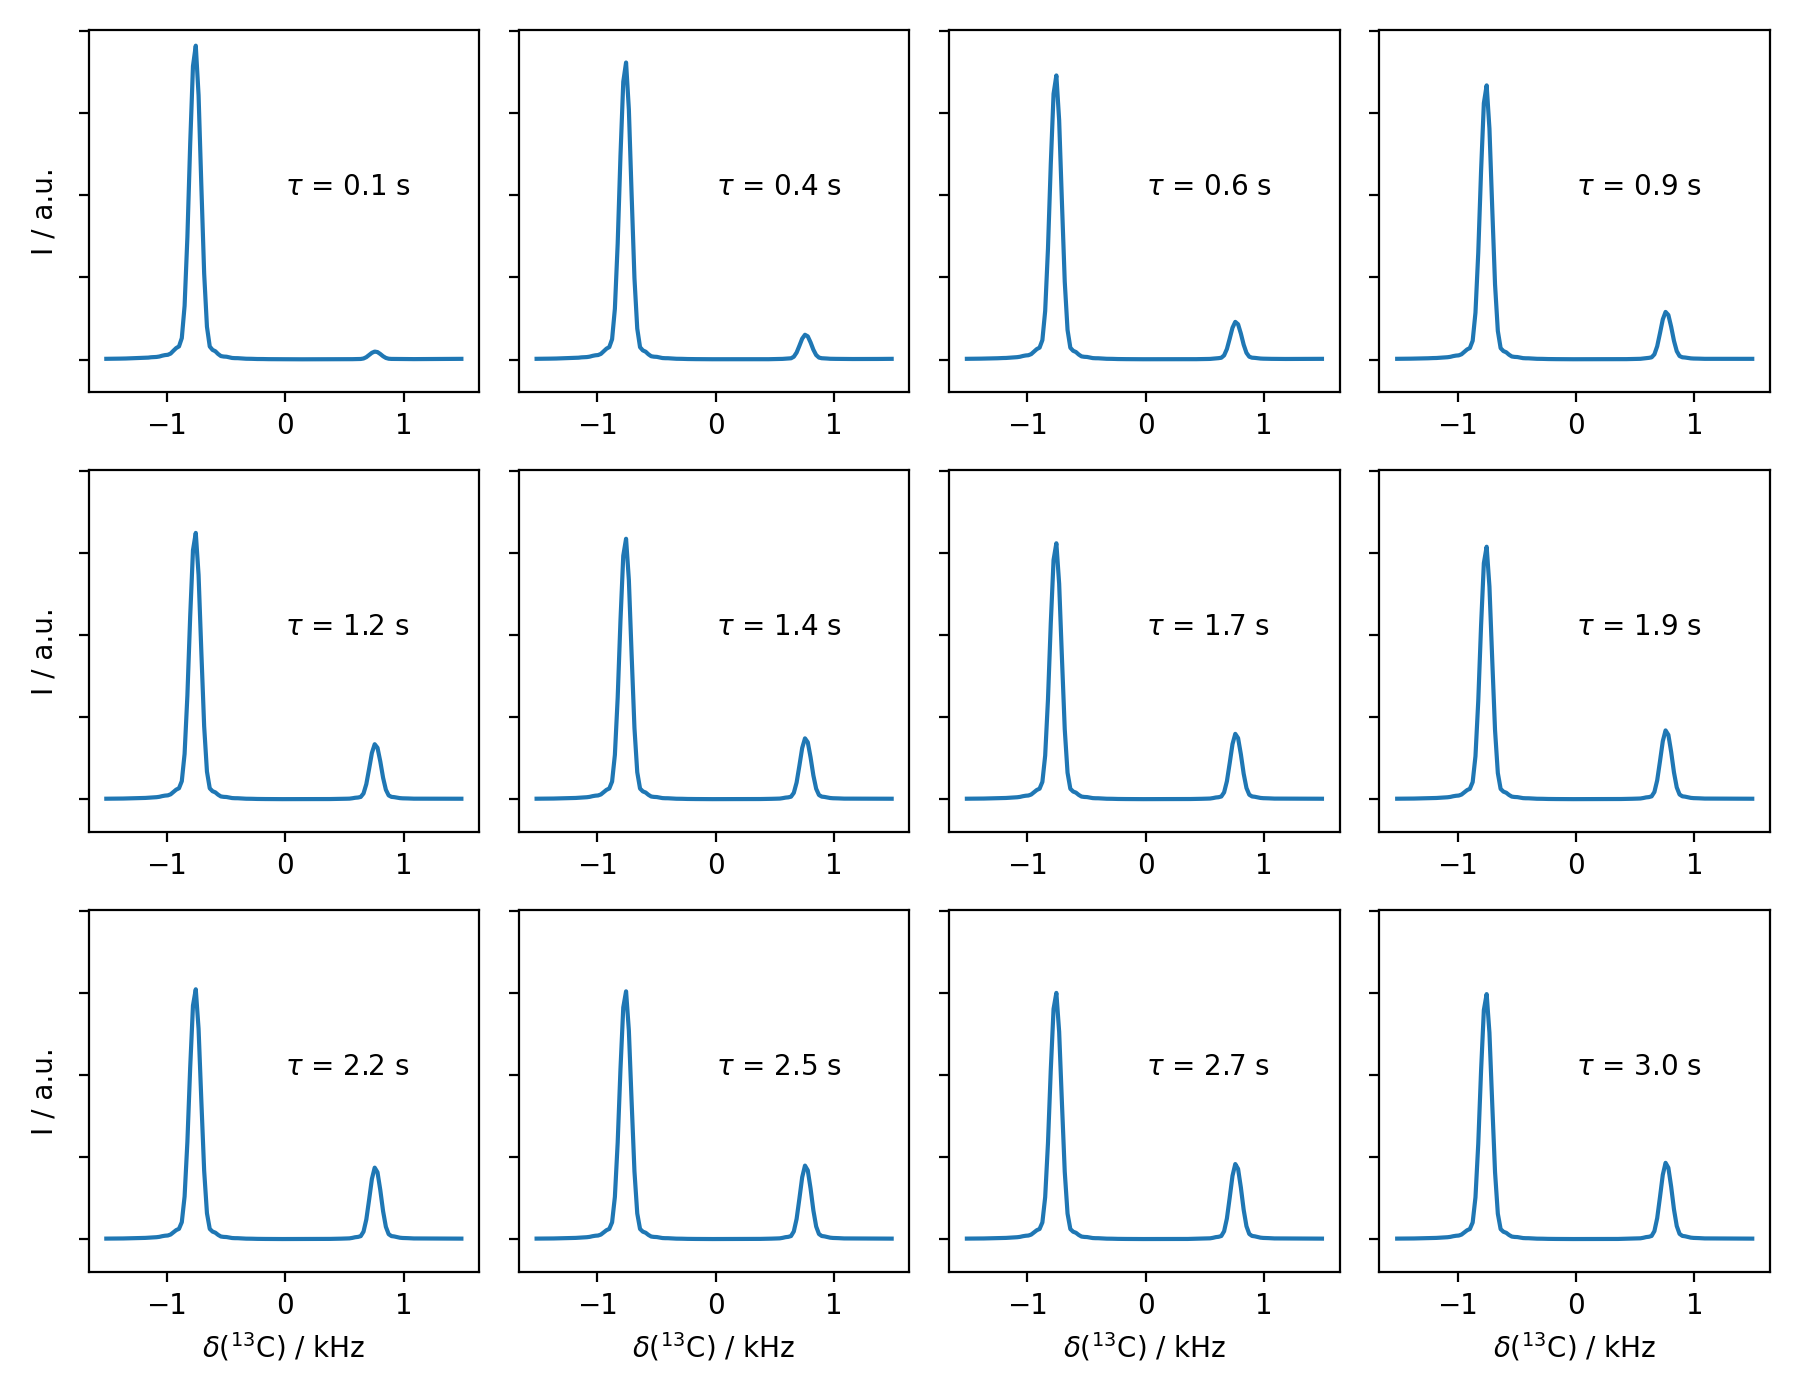

In [27]:
i_dir=[16,48]
i_in=[32,96]

delays=np.linspace(0.1,3,12)
fig,ax=plt.subplots(3,4)
ax=ax.flatten()
sm=None
I=list()
sm=0
for a,delay in zip(ax,delays):
    t=[0,tpi2,delay,delay+tpi2] #pi/2 pulse, 1 second delay, pi/2 pulse
    seq_trX.clear()
    seq_trY.clear()
    seq_trX.add_channel('13C',t=t,v1=[v1,0,v1],phase=[-np.pi/2,0,np.pi/2]) #Convert x to z, delay, convert z to x
    seq_trY.add_channel('13C',t=t,v1=[v1,0,v1],phase=[0,0,np.pi/2]) #Convert y to z, delay, convert z to x

    twoD=sl.Tools.TwoD_Builder(rho,seq_dir=seq,seq_in=seq,seq_trX=seq_trX,seq_trY=seq_trY)
    twoD(32,64).proc()
    
    a.plot(twoD.v_in/1e3,twoD.Sreal[i_dir[0]].real)
    sm=max(a.get_ylim()[1],sm)
    
    I.append([twoD.Sreal[i_dir[0],i_in[0]].real,twoD.Sreal[i_dir[1],i_in[1]].real,
             twoD.Sreal[i_dir[0],i_in[1]].real,twoD.Sreal[i_dir[1],i_in[0]].real])

I=np.array(I)

for a,delay in zip(ax,delays):
    a.set_ylim([-sm*.1,sm])
    a.text(0,sm*.5,r'$\tau$'+f' = {delay:.1f} s')
    a.set_yticklabels('')
    if a.is_last_row():
        a.set_xlabel(r'$\delta$($^{13}$C) / kHz')
    if a.is_first_col():
        a.set_ylabel('I / a.u.')
        

        
fig.set_size_inches([9,7])
fig.tight_layout()

## Plot trajectory of the individual peaks
Each peak represents the probability of starting in some state and ending in another state after the delay time, $\tau$

In [28]:
I=np.array(I)

<IPython.core.display.Javascript object>


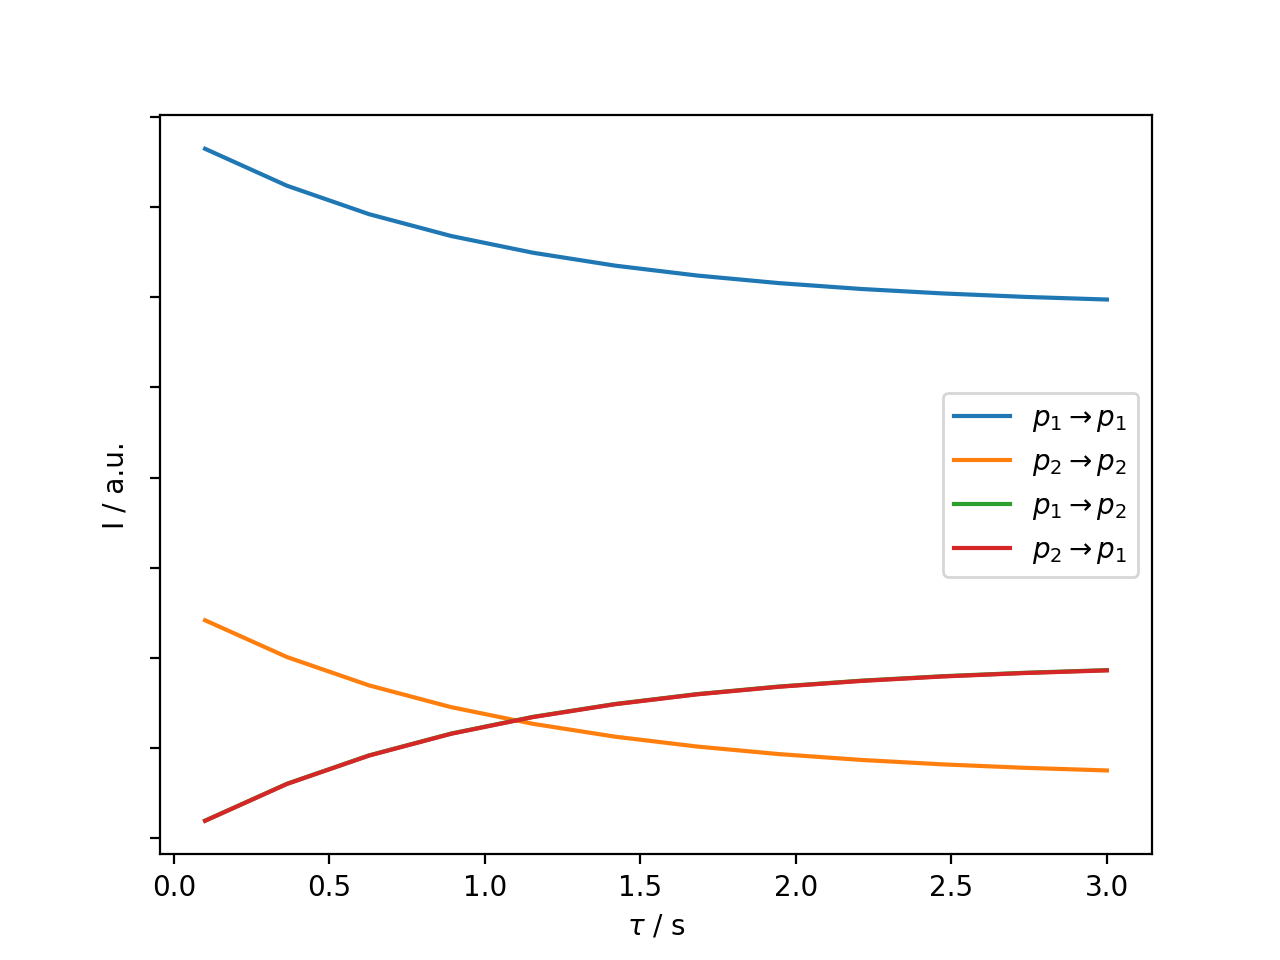

In [29]:
ax=plt.subplots()[1]
ax.plot(delays,I)
ax.set_xlabel(r'$\tau$ / s')
ax.set_ylabel('I / a.u.')
ax.set_yticklabels('')
ax.legend((r'$p_1\rightarrow p_1$',r'$p_2\rightarrow p_2$',r'$p_1\rightarrow p_2$',r'$p_2\rightarrow p_1$'))

## Spectra as a function of exchange rate
We can't use EXSY for faster motions, because the peaks don't stay separated. We can observe this behavior here. We just copy the setup from above for the 3D spectra and run it with varying correlation times

<IPython.core.display.Javascript object>


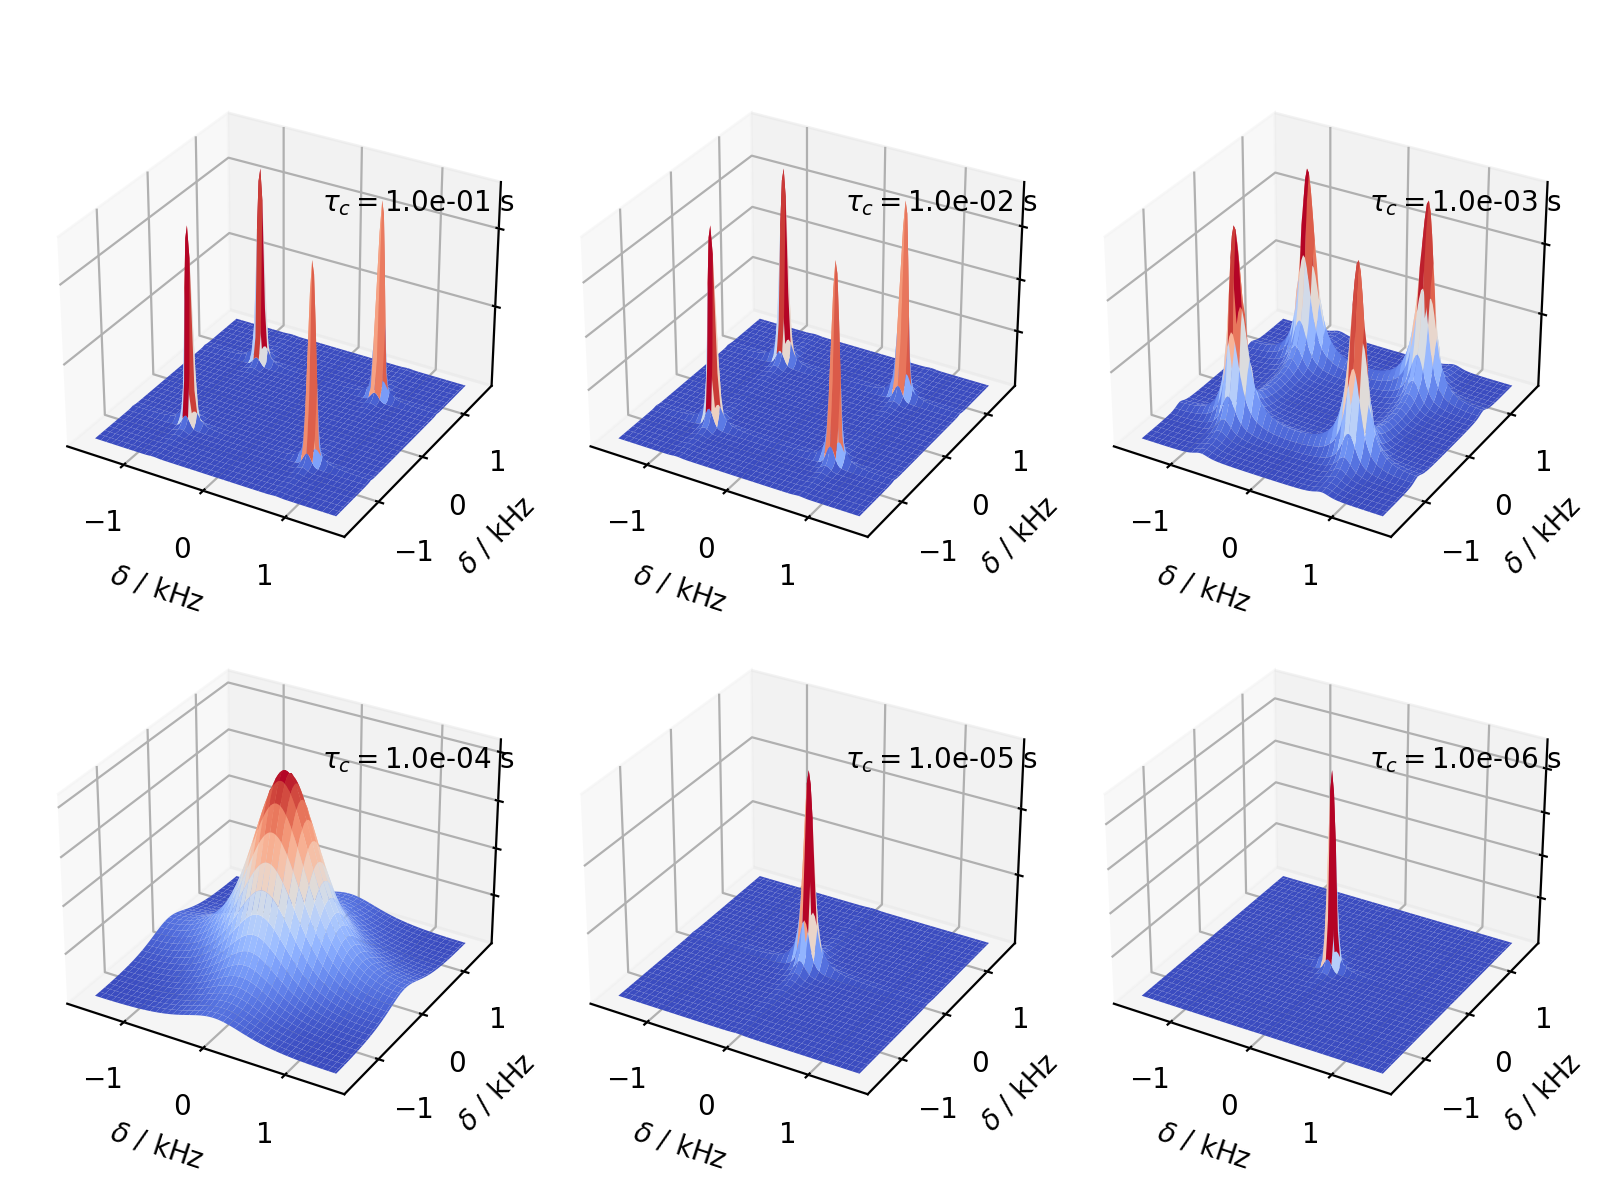

In [31]:
tc0=np.logspace(-1,-6,6)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

fig=plt.figure()
ax=[fig.add_subplot(2,3,k+1,projection='3d') for k in range(6)]
I=list()
for a,tc in zip(ax,tc0):
    L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)
    
    twoD=sl.Tools.TwoD_Builder(rho,seq_dir=seq,seq_in=seq,seq_trX=seq_trX,seq_trY=seq_trY)
    twoD(32,64).proc()
    
    #Plot the result
    twoD.plot(ax=a)
    a.text(1,-1,a.get_zlim()[1]*1.3,r'$\tau_c = $'+f'{tc:.1e} s')
    
fig.set_size_inches(8,6)
fig.tight_layout()
for a in ax:a.set_zticklabels('')

Now we do the same as above, but without having symmetric exchange, i.e. $p_1\ne p_2$.

<IPython.core.display.Javascript object>


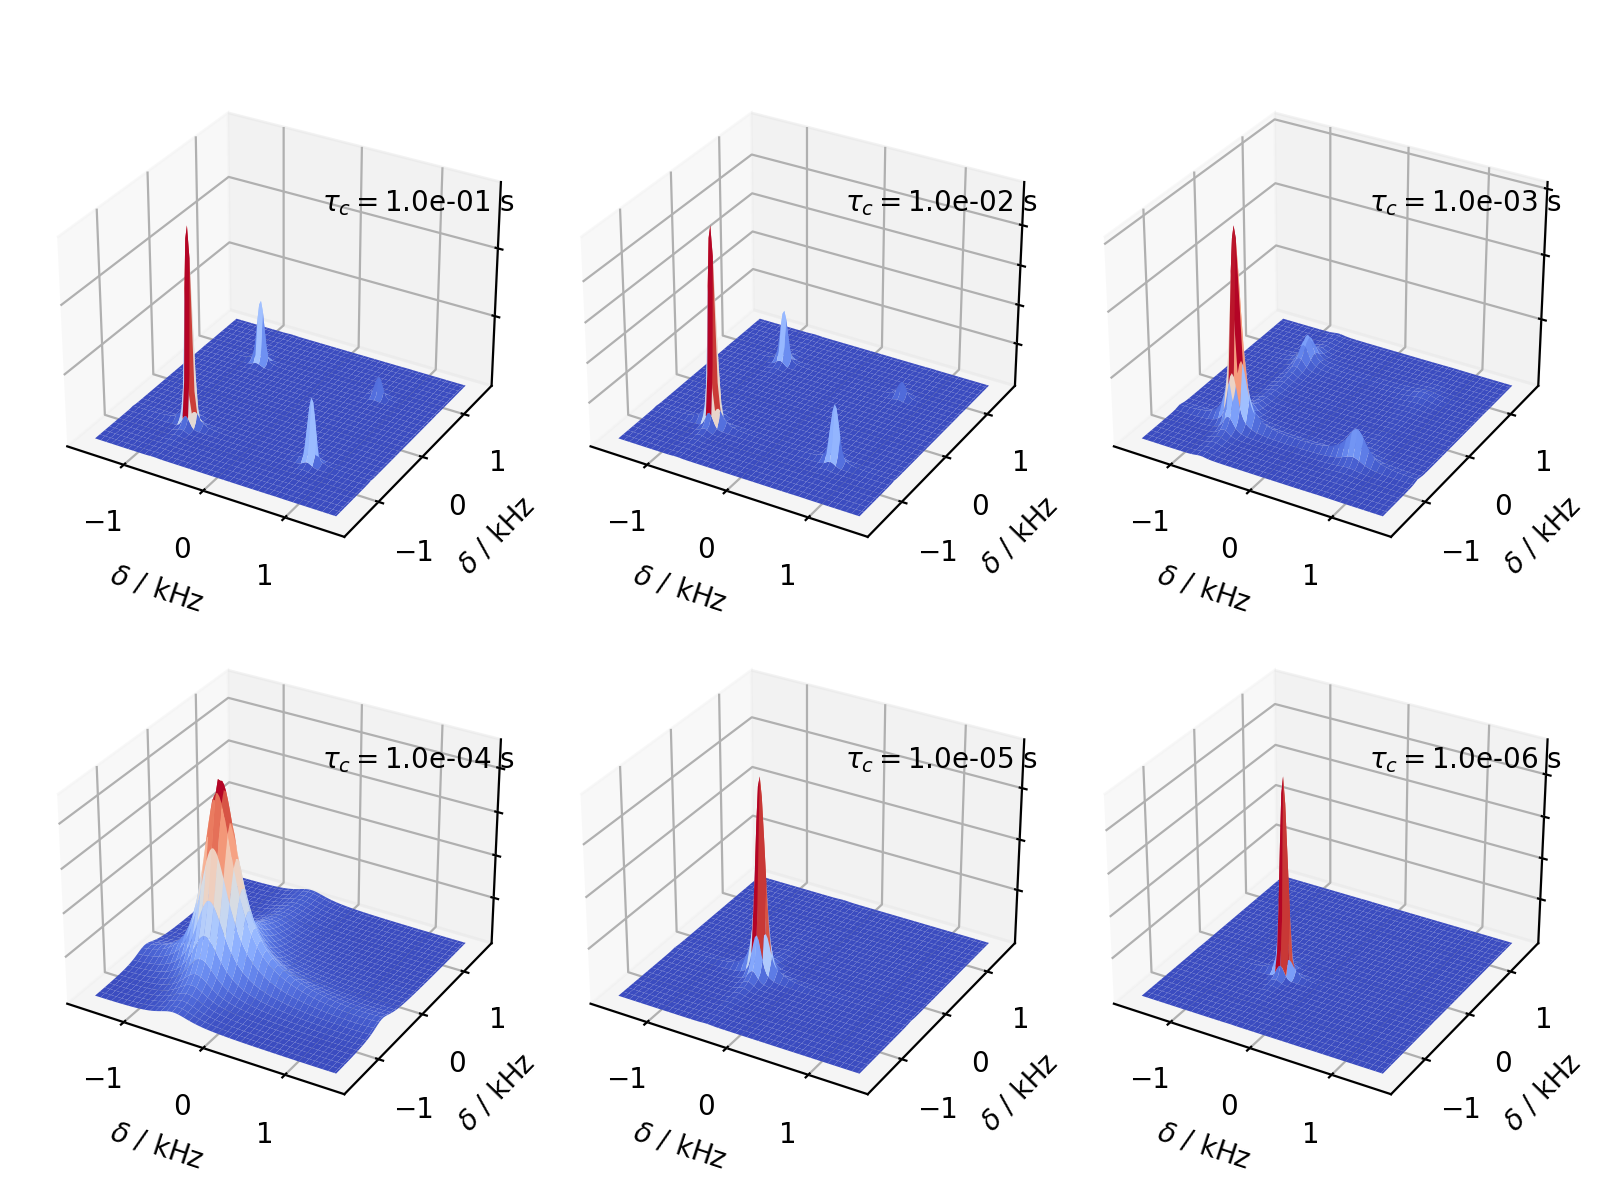

In [32]:
tc0=np.logspace(-1,-6,6)
p1=0.75  #Population of state 1
p2=1-p1  #Population of state 2

fig=plt.figure()
ax=[fig.add_subplot(2,3,k+1,projection='3d') for k in range(6)]
I=list()
for a,tc in zip(ax,tc0):
    L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)
    
    twoD=sl.Tools.TwoD_Builder(rho,seq_dir=seq,seq_in=seq,seq_trX=seq_trX,seq_trY=seq_trY)
    twoD(32,64).proc()
    
    #Plot the result
    twoD.plot(ax=a)
    a.text(1,-1,a.get_zlim()[1]*1.3,r'$\tau_c = $'+f'{tc:.1e} s')
    
fig.set_size_inches(8,6)
fig.tight_layout()
for a in ax:a.set_zticklabels('')

## Explicit execution and processing of the 2D sequence
Above, we have used a built-in class for executing and processing 2D spectra in SLEEPY, however, it may be informative to once execute the whole processing manually.

### Acquisition

In [20]:
# Start from L that has already been generated
L.kex=sl.Tools.twoSite_kex(tc=1,p1=0.75)

rho=sl.Rho(rho0='S0x',detect='S0p')

Uevol=seq.U()

RE=list()
IM=list()
n=64
for k in range(n):
    #First capture the real part
    rho.clear()  #Clear all data in rho
    Uevol**k*rho  #This applies the evolution operator k times
    seq_trX*rho
    rho.DetProp(Uevol,n=n)
    RE.append(rho.I[0])
    
    #Then capture the imaginary part
    rho.clear()  #Clear all data in rho
    Uevol**k*rho  #This applies the evolution operator k times
    seq_trY*rho
    rho.DetProp(Uevol,n=n)
    IM.append(rho.I[0])

### Processing

In [21]:
RE,IM=np.array(RE,dtype=complex),np.array(IM,dtype=complex) #Turn lists into arrays
# Divide first time points by zero
RE[:,0]/=2
RE[0,:]/=2
IM[:,0]/=2
IM[0,:]/=2
# QSINE apodization function
apod=np.cos(np.linspace(0,1,RE.shape[0])*np.pi/2)**2
RE=RE*apod
RE=(RE.T*apod).T
IM=IM*apod
IM=(IM.T*apod).T

nft=n*2
FT_RE=np.fft.fft(RE,n=nft,axis=1).real.astype(complex)
FT_IM=np.fft.fft(IM,n=nft,axis=1).real.astype(complex)
spec=np.fft.fftshift(np.fft.fft(FT_RE+1j*FT_IM,n=nft,axis=0),axes=[0,1])
v=1/(2*Dt)*np.linspace(-1,1,spec.shape[0])  #Frequency axis
v-=(v[1]-v[0])/2 #Shift to have zero at correct position
v*=1e6/ex0.v0[0]   #convert to ppm
vx,vy=np.meshgrid(v,v)  #meshgrid for plotting

### Plotting

<IPython.core.display.Javascript object>


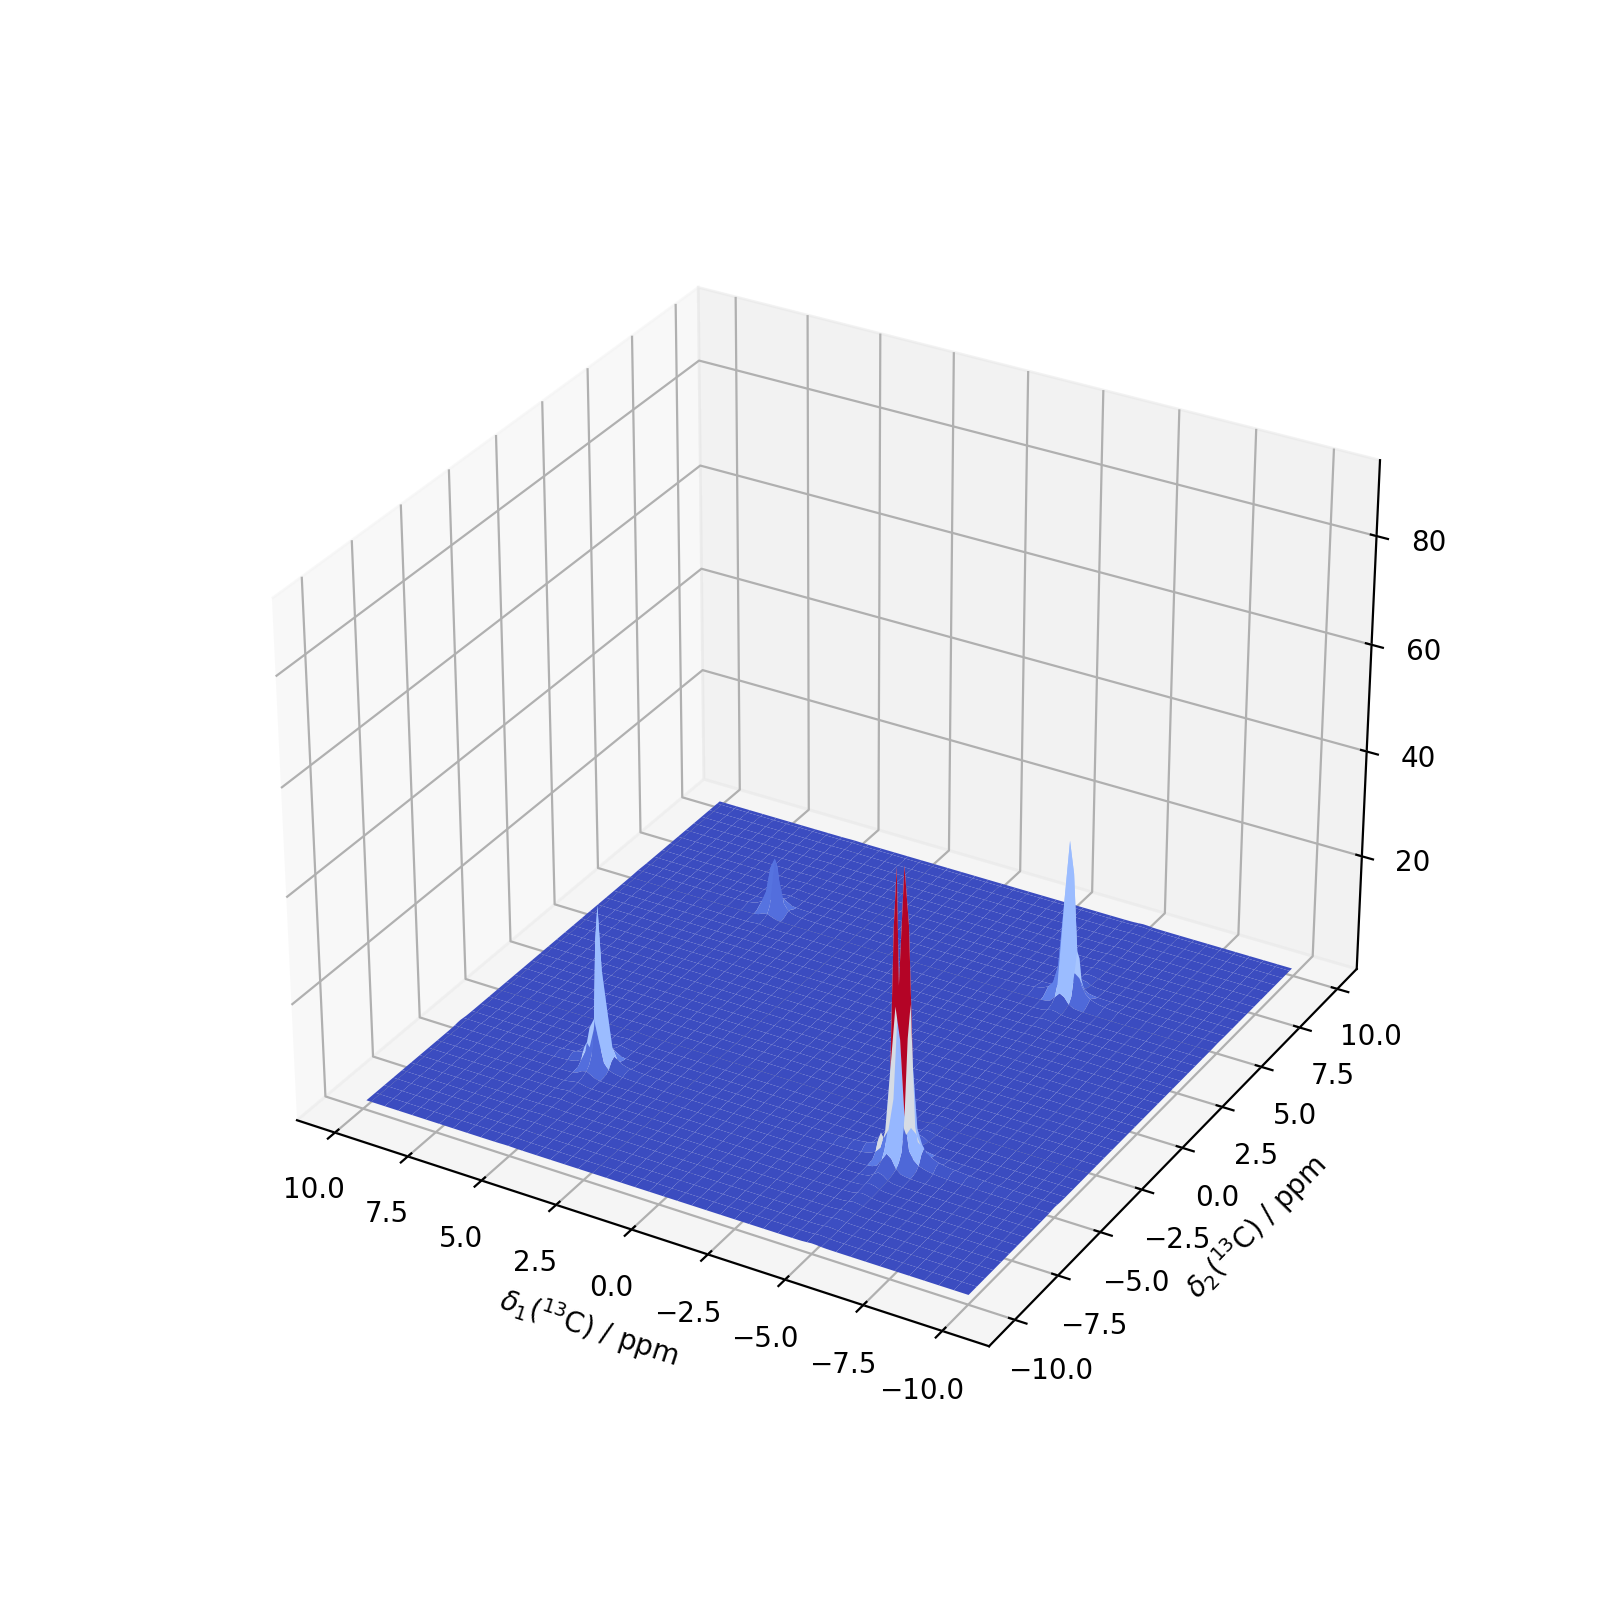

In [22]:
from matplotlib import cm
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(vx,vy,spec.real,cmap='coolwarm',linewidth=0,color='None')
ax.set_xlabel(r'$\delta_1 (^{13}$C) / ppm')
ax.set_ylabel(r'$\delta_2 (^{13}$C) / ppm')
ax.invert_xaxis()
ax.invert_yaxis()

fig.set_size_inches([8,8])